In [1]:
from joblib import dump, load

In [2]:
x_train_mol = load('x_train_mol.pkl')
x_test_mol = load('x_test_mol.pkl')
x_valid_mol = load('x_valid_mol.pkl')

In [36]:
y_train = load('y_train.pkl')
y_test = load('y_test.pkl')
y_valid = load('y_valid.pkl')

In [4]:
len(x_train_mol)

340

In [5]:
len(x_test_mol)

107

In [6]:
len(x_valid_mol)

86

In [18]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, DataStructs
import numpy as np

In [8]:
fp1 = [MACCSkeys.GenMACCSKeys(m1) for m1 in x_train_mol]

In [11]:
fp2 = [MACCSkeys.GenMACCSKeys(m2) for m2 in x_test_mol]

In [12]:
fp3 = [MACCSkeys.GenMACCSKeys(m3) for m3 in x_valid_mol]

In [19]:
def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros([1,])
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [20]:
x_train = rdkit_numpy_convert(fp1)

In [24]:
x_test = rdkit_numpy_convert(fp2)

In [26]:
x_valid = rdkit_numpy_convert(fp3)

In [31]:
dump(x_valid, 'x_valid_maccs.pkl', compress=3)

['x_valid_maccs.pkl']

In [32]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [33]:
seed = 42

In [34]:
cv = StratifiedKFold(n_splits=10, random_state=seed)

D:\Anaconda3\envs\deepchem\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [35]:
from sklearn.preprocessing import StandardScaler

In [42]:
scale = StandardScaler().fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
x_valid_scaled = scale.transform(x_valid)

In [50]:
from sklearn.svm import SVC

In [55]:
param_grid = {'C': [10**i for i in range(-6, 7)],
             'gamma': [10**i for i in range(-6, 7)]}

In [56]:
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)

In [57]:
svm.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:    9.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000, 10000, 100000, 1000000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100, 1000, 10000, 100000, 1000000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [58]:
svm.best_params_

{'C': 10, 'gamma': 0.001}

In [59]:
svm.best_score_

0.7676470588235295

In [146]:
svm_2c8 = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed, C=9, gamma=0.004)

In [147]:
svm_2c8.fit(x_train_scaled, y_train)

SVC(C=9, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.004, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, roc_auc_score, make_scorer, recall_score

In [66]:
matthews = make_scorer(matthews_corrcoef)
specificity = make_scorer(recall_score, pos_label=0)

In [148]:
cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring='accuracy').mean()

0.7676470588235293

In [149]:
cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring='roc_auc').mean()

0.8504197994987468

In [150]:
cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring=matthews).mean()

0.5370591429690029

In [151]:
cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring='recall').mean()

0.7926315789473685

In [152]:
cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring=specificity).mean()

0.7300000000000001

In [153]:
y_pred = svm_2c8.predict(x_test_scaled)

In [154]:
y_pred

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0])

In [155]:
accuracy_score(y_test, y_pred)

0.7570093457943925

In [156]:
roc_auc_score(y_test, svm_2c8.decision_function(x_test_scaled))

0.8266814486326681

In [157]:
matthews_corrcoef(y_test, y_pred)

0.4778336686655522

In [158]:
recall_score(y_test, y_pred)

0.8333333333333334

In [159]:
recall_score(y_test, y_pred, pos_label=0)

0.6341463414634146

In [80]:
import matplotlib.pyplot as plt

0.7705882352941177 0
0.7570093457943925 4


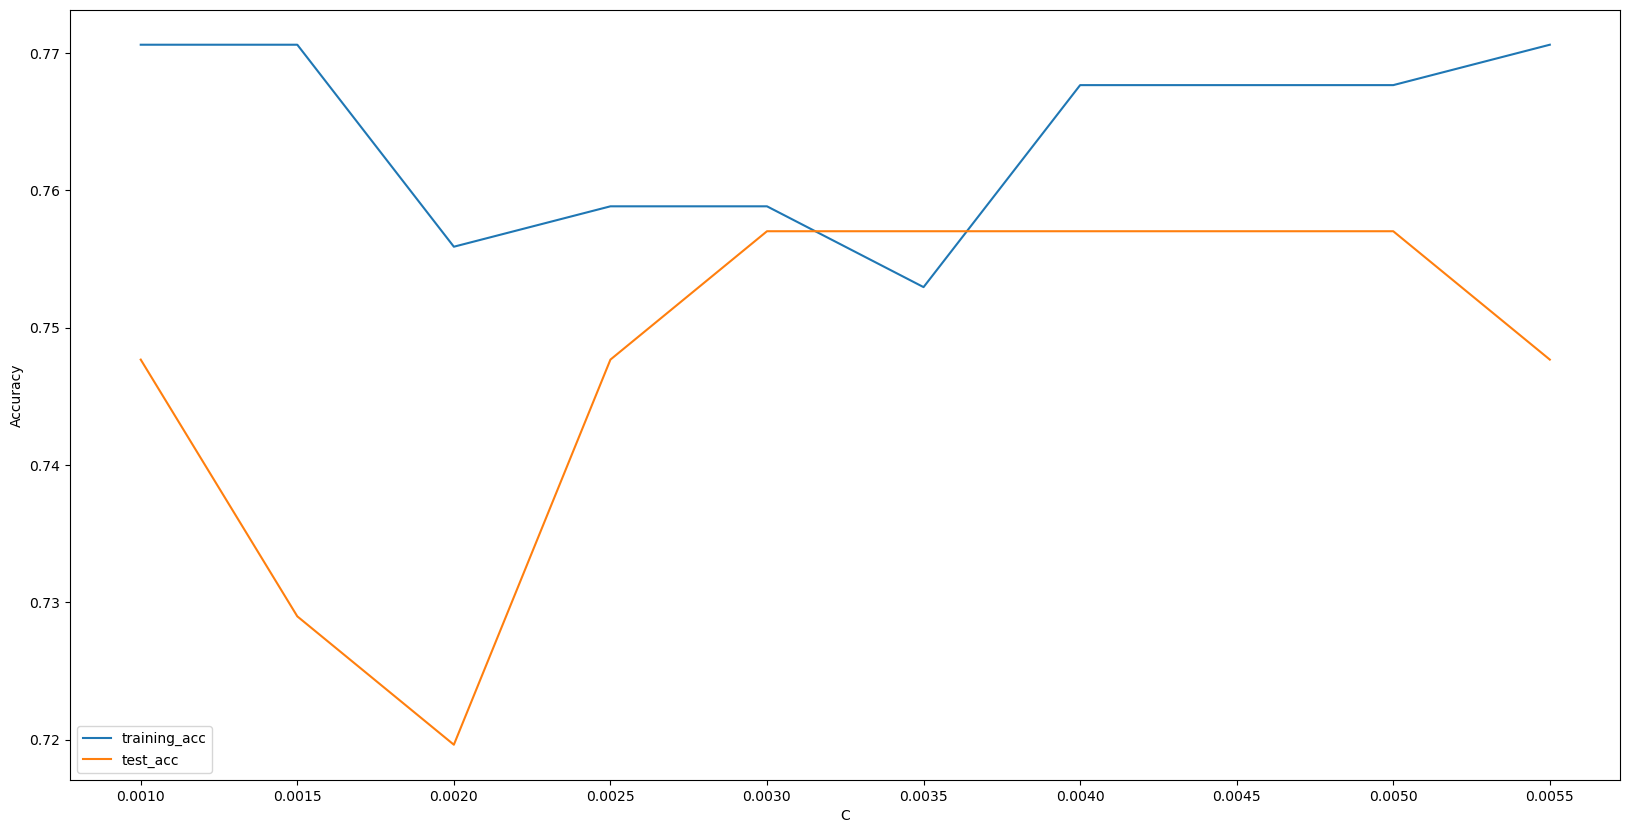

In [160]:
training_acc = []
test_acc = []

for i in np.arange(0.001, 0.006, 0.0005):
    svm_2c8 = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=seed, C=9, gamma=i)
    svm_2c8.fit(x_train_scaled, y_train)
    training_acc.append(cross_val_score(svm_2c8, x_train_scaled, y_train, cv=cv, scoring='accuracy').mean())
    y_pred = svm_2c8.predict(x_test_scaled)
    test_acc.append(accuracy_score(y_test, y_pred))
print(max(training_acc),(training_acc.index(max(training_acc))))
print(max(test_acc),(test_acc.index(max(test_acc))))
plt.figure(figsize=(20, 10))
plt.plot(np.arange(0.001, 0.006, 0.0005), training_acc, label="training_acc")
plt.plot(np.arange(0.001, 0.006, 0.0005), test_acc, label="test_acc")
plt.xlabel("C")
plt.ylabel("Accuracy")
xticks = np.arange(0.001, 0.006, 0.0005)
plt.xticks(xticks)
plt.legend()

In [161]:
y_pred_valid = svm_2c8.predict(x_valid_scaled)

In [162]:
accuracy_score(y_valid, y_pred_valid)

0.813953488372093

In [163]:
roc_auc_score(y_valid, svm_2c8.decision_function(x_valid_scaled))

0.923076923076923

In [164]:
matthews_corrcoef(y_valid, y_pred_valid)

0.6241566459895869

In [165]:
recall_score(y_valid, y_pred_valid)

0.8723404255319149

In [166]:
recall_score(y_valid, y_pred_valid, pos_label=0)

0.7435897435897436

In [167]:
dump(svm_2c8, '2c8_maccs_svm.pkl', compress=3)

['2c8_maccs_svm.pkl']